# Attention Mechanism Homework on Pytorch Lightning: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
!pip install pytorch-lightning wandb
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-03-25 08:55:58--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2023-03-25 08:55:58--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.1’

thsarabunnew

In [2]:
!wandb login

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [4]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2023-03-25 08:56:04--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv.1’

mp_name_th_en.csv.1 100%[===================>] 316.80K  --.-KB/s    in 0.003s  

2023-03-25 08:56:04 (114 MB/s) - ‘mp_name_th_en.csv.1’ saved [324399/324399]



In [5]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [6]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [7]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max input length

There are 10887 lines and 65 unique characters in your input data.


In [8]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [9]:
sorted_chars= sorted(input_chars)
sorted_output_chars= sorted(output_chars)
sorted_chars.insert(0,"<PAD>") #PADDING for input
sorted_output_chars.insert(0,"<PAD>") #PADDING for output
sorted_output_chars.append("</s>") #end of word symbol for output

#input vocab
input_vocab = torchtext.vocab.vocab({})
for char in sorted_chars:
  input_vocab.append_token(char) 

#output vocab
output_vocab = torchtext.vocab.vocab({})
for char in sorted_output_chars:
  output_vocab.append_token(char) 

In [10]:
print(sorted(input_vocab.get_stoi().items(), key=lambda item: item[1]))
print(sorted(output_vocab.get_stoi().items(), key=lambda item: item[1]))

[('<PAD>', 0), (' ', 1), ('ก', 2), ('ข', 3), ('ค', 4), ('ฆ', 5), ('ง', 6), ('จ', 7), ('ฉ', 8), ('ช', 9), ('ซ', 10), ('ฌ', 11), ('ญ', 12), ('ฎ', 13), ('ฏ', 14), ('ฐ', 15), ('ฑ', 16), ('ฒ', 17), ('ณ', 18), ('ด', 19), ('ต', 20), ('ถ', 21), ('ท', 22), ('ธ', 23), ('น', 24), ('บ', 25), ('ป', 26), ('ผ', 27), ('ฝ', 28), ('พ', 29), ('ฟ', 30), ('ภ', 31), ('ม', 32), ('ย', 33), ('ร', 34), ('ล', 35), ('ว', 36), ('ศ', 37), ('ษ', 38), ('ส', 39), ('ห', 40), ('ฬ', 41), ('อ', 42), ('ฮ', 43), ('ะ', 44), ('ั', 45), ('า', 46), ('ำ', 47), ('ิ', 48), ('ี', 49), ('ึ', 50), ('ื', 51), ('ุ', 52), ('ู', 53), ('เ', 54), ('แ', 55), ('โ', 56), ('ใ', 57), ('ไ', 58), ('็', 59), ('่', 60), ('้', 61), ('๊', 62), ('๋', 63), ('์', 64)]
[('<PAD>', 0), ('-', 1), ('a', 2), ('b', 3), ('c', 4), ('d', 5), ('e', 6), ('f', 7), ('g', 8), ('h', 9), ('i', 10), ('k', 11), ('l', 12), ('m', 13), ('n', 14), ('o', 15), ('p', 16), ('r', 17), ('s', 18), ('t', 19), ('u', 20), ('w', 21), ('y', 22), ('</s>', 23)]


In [11]:
X = []
for line in name_th:
  line = [l for l in line]
  X.append(torch.tensor(input_vocab(line)))
y = []
for line in name_en:
  line = [l for l in line]
  line.append('</s>')
  y.append(torch.tensor(output_vocab(line)))

X = nn.utils.rnn.pad_sequence(X, batch_first = True) 
y = nn.utils.rnn.pad_sequence(y, batch_first = True) 

maxlen = X.size(-1)
maxlen_out = y.size(-1)
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 20


In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
class NameDataset(Dataset):
  def __init__(self, X, y):
    self.encoded = X.long()
    self.label = y.long()
    
  def __getitem__(self, idx):
    return {'x': self.encoded[idx], 'y': self.label[idx]}

  def __len__(self):
    return len(self.encoded)

In [14]:
class NameDataModule(pl.LightningDataModule):

  def __init__(self, train_data, y, batch_size, num_workers=0):
    super().__init__()
    self.train_data = train_data
    self.y = y
    self.batch_size = batch_size
    self.num_workers = num_workers
 
  def setup(self, stage: str):
    pass

  def collate_fn(self, batch):
    one_hot_x = torch.stack( [F.one_hot(b['x'], num_classes=len(input_vocab)) for b in batch])
    return {'x': one_hot_x.float(), 'y': torch.stack([b['y'] for b in batch])}

  def train_dataloader(self):
    train_dataset = NameDataset(self.train_data, self.y)
    train_loader = DataLoader(train_dataset,
                              batch_size = self.batch_size,
                              shuffle = True,
                              collate_fn = self.collate_fn,
                              num_workers = self.num_workers)
    return train_loader


In [15]:
batch_size = 16
data_module = NameDataModule(X, y, batch_size=batch_size, num_workers=0)

# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [16]:
def one_step_attention(h, s_prev, W1, W2):
    #Split into Key-Value
    key, value = torch.split(h, h.size(-1)//2, dim=-1)
    # print('key', key.shape) ; print('value', value.shape)

    #do concat with s_prev. 
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful
    s_prev = s_prev.unsqueeze(dim=1).repeat((1, h.size(1), 1)) # copy to have length == maxlen (h.size(1))
    concat = torch.cat([key, s_prev], dim=-1)
    # print('s_prev', s_prev.size()) ; print('concat', concat.size())

    #Attention function### 
    # use layer(s) from your model to calculate attention_scores and then softmax
    e = torch.tanh(W1(concat))
    energy = F.relu(W2(e))
    attention_score = F.softmax(energy, dim=1)
    # print('e', e.size()); print('energy', energy.size()) ; print('att sc', attention_score.size())

    # calculate a context vector
    r_t = torch.mul(attention_score, value).sum(dim=1)
    # print('r_t', r_t.size())

    return r_t, attention_score

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [17]:
class AttentionModel(pl.LightningModule):
    def __init__(self, learning_rate, criterion):
                
        super().__init__()
        self.n_h = 32 #hidden dimensions for encoder 
        self.n_s = 32 #hidden dimensions for decoder

        self.learning_rate = learning_rate
        self.criterion = criterion

        #encoder can be any RNN of your choice
        self.num_directions = 2 # bi-direction
        self.lstm = nn.LSTM(len(input_vocab), self.n_h, bidirectional=True, batch_first=True)
        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(output_vocab))
        #attention
        self.W1 = nn.Linear(self.n_h*self.num_directions, self.n_h)
        self.W2 = nn.Linear(self.n_h, 1)

    def forward(self, src, return_attention=False): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        lstm_out, _ = self.lstm(src) 
        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], maxlen_out, len(output_vocab))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(maxlen_out):
            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.W1, self.W2)
            attention_scores.append(attention_score)
            # print('contxt, att', context.shape, attention_score.shape)

            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))
            # print('decoder_s, c', decoder_s.shape, decoder_c.shape)

            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)
            # print('out', out.shape)
            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch['x']
        target = batch['y']
        # print('src,tar', src.size(), target.size())
        prediction,_ = self(src)
        # print('pred,tar',prediction.size(), target.size())
        prediction = prediction.reshape(-1, len(output_vocab))
        target = target.reshape(-1)
        # print('pred,tar',prediction.size(), target.size())
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        print('pred_step')

        src = batch['x']
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
            print("".join(output_vocab.lookup_tokens(pred.cpu().numpy())))
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [18]:
criterion = nn.CrossEntropyLoss()
lr = 1e-2
model = AttentionModel(lr, criterion)

In [19]:
batch_size = 16
data_module = NameDataModule(X, y, batch_size=batch_size, num_workers=0)

In [20]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw8_attention")

wandb: Currently logged in as: poraree. Use `wandb login --relogin` to force relogin


In [21]:
trainer = pl.Trainer(
    max_epochs=30,
    accelerator='gpu',
    devices=1,
    logger=wandb_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type             | Params
-------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0     
1 | lstm              | LSTM             | 25.3 K
2 | decoder_lstm_cell | LSTMCell         | 8.4 K 
3 | output_layer      | Linear           | 792   
4 | W1                | Linear           | 2.1 K 
5 | W2                | Linear           | 33    
-------------------------------------------------------
36.7 K    Trainable params
0         Non-trainable params
36.7 K    Total params
0.147     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

In [54]:
EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ','ปรวีร์']

In [55]:
predict_data = []
for line in EXAMPLES:
    line = [l for l in line]
    predict_data.append(torch.tensor(input_vocab(line)))

print(len(predict_data))    

def collate_fn(batch):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_vocab)) for b in batch])
    return {"x": one_hot_x.float()}

predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first = True)
predict_dataset = NameDataset(predict_data, torch.Tensor([torch.tensor(0)]*len(predict_data)))
predict_loader = DataLoader(predict_dataset, 
                          batch_size = 1, 
                          shuffle = False, 
                          collate_fn = collate_fn,
                          num_workers = 0)

8


In [56]:
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (lstm): LSTM(65, 32, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(32, 32)
  (output_layer): Linear(in_features=32, out_features=24, bias=True)
  (W1): Linear(in_features=64, out_features=32, bias=True)
  (W2): Linear(in_features=32, out_features=1, bias=True)
)

In [57]:
output = trainer.predict(model, predict_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

pred_step
prryyutttttttttccccc
pred_step
smmchai</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
pred_step
ttttnnattttrrrat</s></s></s></s>
pred_step
ndwin</s>d<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
pred_step
sutheppthe</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
pred_step
prrwwit</s>ciwcaaaaaaaa
pred_step
ccchatccccccccccccat
pred_step
prrwwi</s><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


## TODO 5: Show your visualization of attention scores on one of your example

In [58]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
prediction, attention_scores = zip(*output)

In [60]:
idx_to_chars = output_vocab.get_itos()

In [61]:
input_text = [ch for ch in EXAMPLES[-1]] + ['<PAD>' for _ in range(8 - len(EXAMPLES[-1]))]

In [62]:
output_text = [idx_to_chars[id] for id in prediction[-1][0].numpy()]

In [63]:
attn_viz = torch.stack(attention_scores[-1]).squeeze()

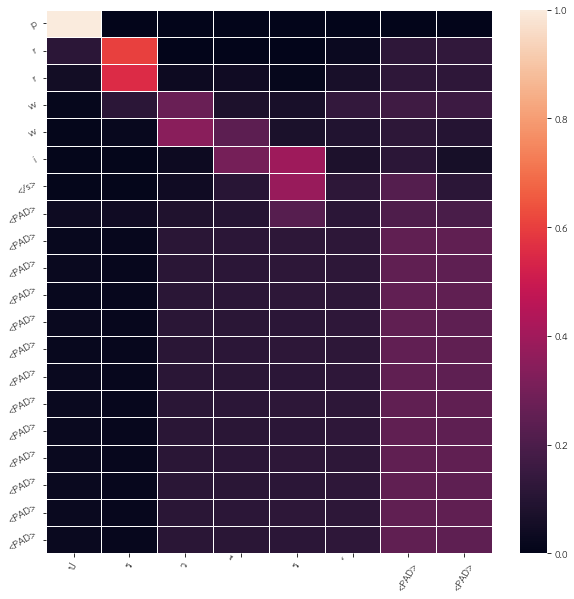

In [69]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text,rotation=30)
ax.set_xticklabels(input_text,rotation=60)
plt.show()